# Домашнее задание №3

In [2]:
# Данные для определения вариантов в дальнейшем
group, number = input("Input group and list number: ").split()

## Задание 1
Разработать программу, принимающую на вход изображение из категории Imagenet своего варианта и
выдающее название категории изображенного объекта и вероятность соответствия его этой категории.

In [3]:
# Номер варианта
cls_number = int(group[-1]) * 20 + int(number) * 10
print("Class number:", cls_number)

Class number: 220


In [4]:
import os
import pickle

import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet18, ResNet18_Weights
from torch.nn.functional import softmax

In [5]:
def load_databatch(data_folder, file_name, img_size=64):
    data_file = os.path.join(data_folder, file_name)
    with open(data_file, 'rb') as f:
        d = pickle.load(f)

    X = d['data']
    y = d['labels']

    X = X.reshape(-1, 3, img_size, img_size)
    y = [i-1 for i in y]

    return [X, y]

In [6]:
data_folder = "Imagenet64/Imagenet64_val/"
file_name = "val_data"

X, y = load_databatch(data_folder, file_name)

print("Shape of X:", X.shape)
print("Length of y:", len(y))

Shape of X: (50000, 3, 64, 64)
Length of y: 50000


In [7]:
cls_indices = [i for i in range(len(y)) if y[i] == cls_number]

X_test = X[cls_indices]
y_test = [y[i] for i in cls_indices]

print("Shape of X_test:", X_test.shape)
print("Length of y_test:", len(y_test))

Shape of X_test: (50, 3, 64, 64)
Length of y_test: 50


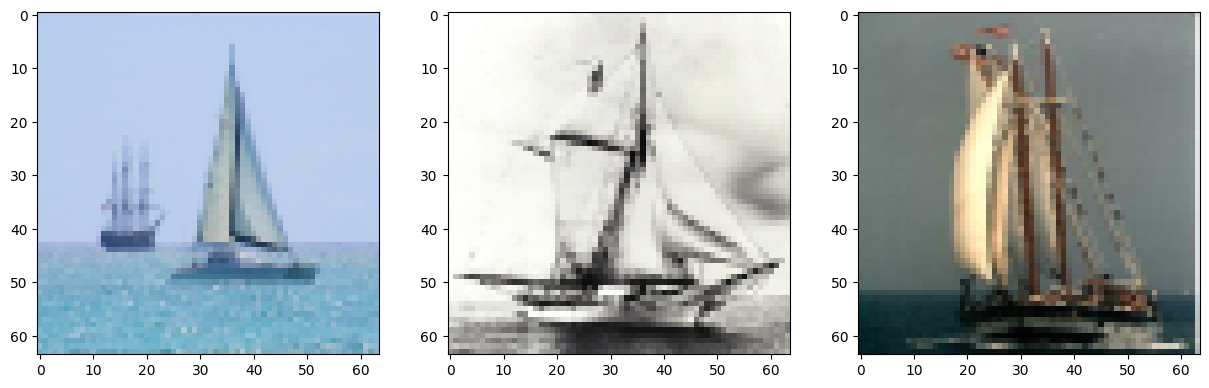

In [8]:
im_number = 3

fig, axes = plt.subplots(1, im_number)
fig.set_size_inches(5 * im_number, 5)

for i in range(im_number):
    axes[i].imshow((X_test[i]).transpose(1, 2, 0))

In [9]:
with open("Imagenet64/Imagenet_classes.txt", 'r') as f:
    classes = [label[1:-1] for id, label in [line.split(',') for line in f]]

print('Head of classes list:')
print(classes[:10])

Head of classes list:
['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich']


In [10]:
def predict_class(model, preprocess, imgs):
    batch = preprocess(imgs)
    prediction = model(batch).softmax(dim=1)
    class_id = prediction.argmax(dim=1)
    return [class_id, prediction]

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()
model = resnet18(weights=weights).to(device).eval()

test_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_test).to(device),
    torch.tensor(y_test).to(device)
), batch_size=8, num_workers=8)

pred_dict = {'label': [], 'confidence': []}

with torch.no_grad():
    for batch in test_dataloader:
        imgs, labels = batch
        pred_cls, pred_softmax = predict_class(model, preprocess, imgs)
        pred_dict['label'].extend([classes[i] for i in pred_cls])
        pred_dict['confidence'].extend(
            [pred_softmax[i, pred_cls[i]].item() for i in range(pred_softmax.shape[0])])

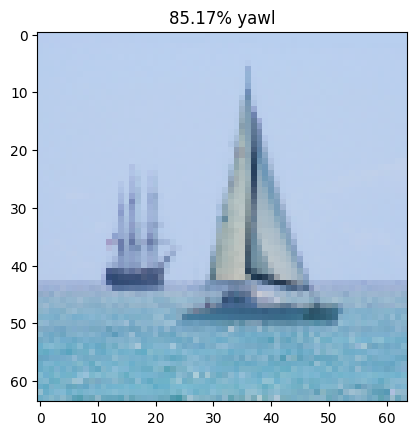

In [12]:
id = 0
plt.title(f"{pred_dict['confidence'][id] * 100:.2f}% {pred_dict['label'][id]}")
plt.imshow(X_test[id].transpose(1, 2, 0).astype(np.uint8))

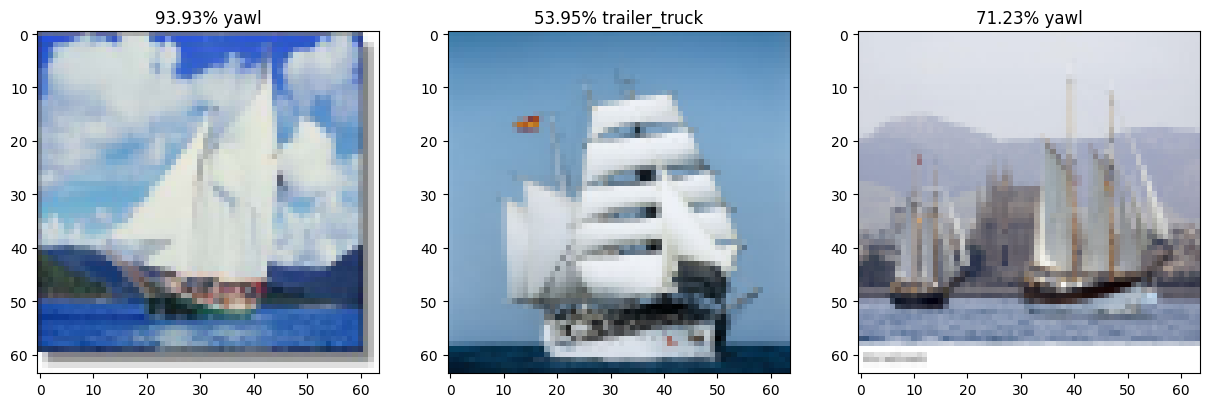

In [13]:
im_number = 3
tick = 8

fig, axes = plt.subplots(1, im_number)
fig.set_size_inches(5 * im_number, 5)

for i in range(im_number):
    axes[i].set_title(
        f"{pred_dict['confidence'][10 + i * tick] * 100:.2f}% {pred_dict['label'][10 + i * tick]}")
    axes[i].imshow((X_test[10 + i * tick]).transpose(1, 2, 0))

## Задание 2
Разработать программу, распознающую на изображении по вариантам с использованием дообучения:
1. день/ночь;
2. помещение/улица;
3. человек/животное;
4. мужчина/женщина.

In [14]:
# Номер варианта
cat_number = int(number) % 4 + 1
print("Category number:", cat_number)

Category number: 3


In [15]:
from glob import glob

from PIL import Image

import numpy as np

import torch
from torch.nn import MSELoss
from torch.optim import AdamW
from torch.utils.data import random_split, TensorDataset, DataLoader
from torchvision.models import resnet18, ResNet18_Weights

from tqdm import tqdm

from matplotlib import pyplot as plt

In [16]:
def load_data(data_folder):
    img_data = []
    for file in tqdm(glob(data_folder + 'Image\\*\\*.jpg')):
        with Image.open(file) as img:
            img_data.append(np.array(img.resize((256, 256))))
    img_data = np.stack(img_data).transpose(0, 3, 1, 2)
    
    tags = []
    for file in tqdm(glob(data_folder + 'time_stamp\\*.txt')):
        with open(file) as f:
            for line in f.read().split('\n')[:-1]:
                hour = int(line[-5:-3])
                if (hour > 10) and (hour < 22):
                    tags.append(1.)
                else:
                    tags.append(0.)
    return [img_data, tags]

In [16]:
data_folder = "DNIM\\"
X, y = load_data(data_folder)

print("Shape of X:", X.shape)
print("Length of y:", len(y))

100%|██████████| 17/17 [00:00<00:00, 99.20it/s]


Shape of X: (1722, 3, 256, 256)
Length of y: 1722


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()
model = resnet18(weights=weights).to(device)
model.fc = torch.nn.Linear(512, 1)
model.train()

optimizer = AdamW(model.fc.parameters(), lr=0.0001)
criterion = MSELoss()

train_dataset, test_dataset = random_split(TensorDataset(
    torch.tensor(X, dtype=torch.float32),
    torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
), lengths=[0.8, 0.2])

batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8)

loss_list = []

epochs = 3
for i in range(epochs):
    print(f'Train epoch #{i}')
    for imgs, labels in tqdm(train_dataloader):
        pred = model(preprocess(imgs).to(device))

        loss = criterion(pred, labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        loss_list.append(loss.item())

Train epoch #0


  0%|          | 11/5000 [01:00<7:38:38,  5.52s/it]


KeyboardInterrupt: 

In [19]:
model.eval()

preds = np.expand_dims([], axis=1)
with torch.no_grad():
    for imgs, labels in tqdm(test_dataloader):
        preds = np.concatenate([preds, model(preprocess(imgs)).numpy()], axis=0)

preds[preds < 0.5] = 0
preds[preds >= 0.5] = 1
preds = preds.astype(np.uint8)

100%|██████████| 43/43 [00:27<00:00,  1.57it/s]


In [20]:
print("Acuracy:", np.mean(test_dataset[:][1].numpy() == preds))

Acuracy: 0.872093023255814


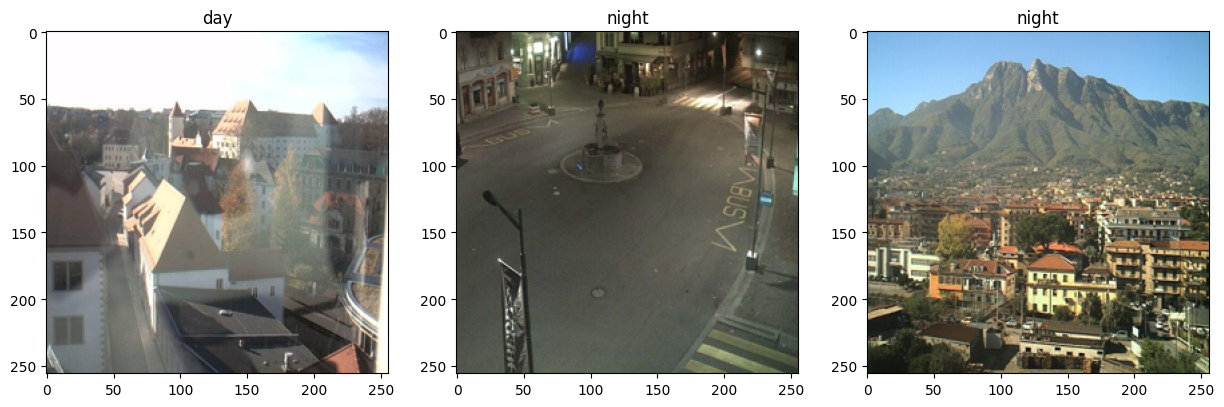

In [21]:
im_number = 3
fig, axes = plt.subplots(1, im_number)
fig.set_size_inches(5 * im_number, 5)

for idx in range(len(test_dataset)):
    axes[idx].imshow(test_dataset[idx][0].numpy().astype(np.uint8).transpose(1, 2, 0))
    if preds[idx][0] == 1:
        title = 'day'
    else:
        title = 'night'
    axes[idx].set_title(title)
    if idx == im_number - 1:
        break

## Задание 3
Разработать программу, распознающую по фото не менее 5 эмоций человека на выбор с использованием дообучения.

In [22]:
from PIL import Image

import numpy as np

import torch
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.utils.data import Subset, DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.datasets import DatasetFolder

from tqdm import tqdm

from matplotlib import pyplot as plt

In [23]:
def load_data(file_name):
    data = Image.open(file_name)
    data = data.resize((254, 254))
    data = data.convert('RGB')
    data = np.array(data)
    data = data.transpose(2, 0, 1)
    return data

In [24]:
train_dataset = DatasetFolder('Faces/train/', load_data, tuple('png'))
test_dataset = DatasetFolder('Faces/test/', load_data, tuple('png'))

classes = train_dataset.classes

print('Train dataset length:', len(train_dataset))
print('Test dataset length:', len(test_dataset))
print('Image sample shape:', train_dataset[0][0].shape)

Train dataset length: 28709
Test dataset length: 7178
Image sample shape: (3, 254, 254)


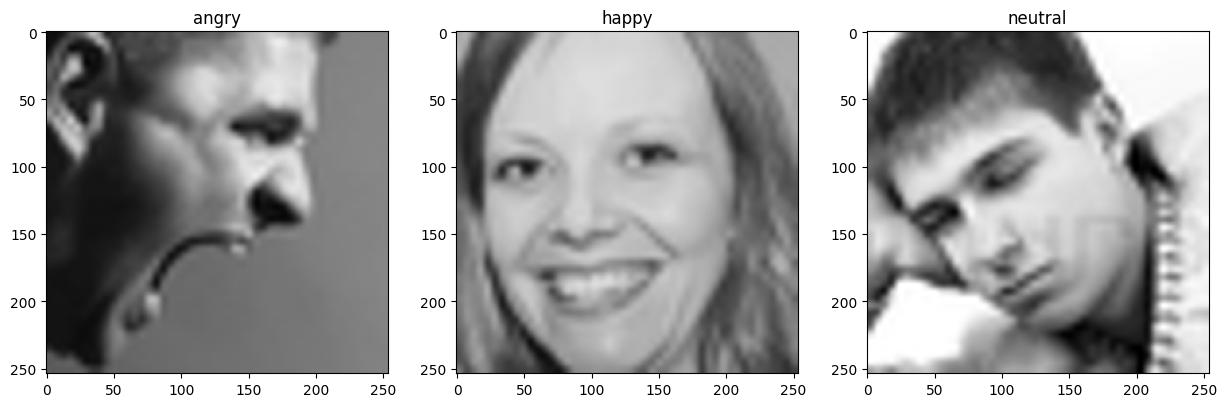

In [25]:
im_number = 3

fig, axes = plt.subplots(1, im_number)
fig.set_size_inches(5 * im_number, 5)

for i in range(im_number):
    im_idx = i * 10000 + 10
    axes[i].imshow(train_dataset[im_idx][0].transpose(1, 2, 0))
    axes[i].set_title(classes[train_dataset[im_idx][1]])

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

model = resnet18(weights=weights).to(device)
model.fc = torch.nn.Linear(512, len(classes))
model.train()

optimizer = AdamW(model.parameters(), lr=0.0001)
criterion = CrossEntropyLoss()

loss_list = []

train_size = 1500
batch_size = 16
epochs = 3

for i in range(epochs):
    print(f'Train epoch #{i}')

    train_indices = np.random.randint(0, len(train_dataset), train_size)
    train_subset = Subset(train_dataset, list(train_indices))
    train_dataloader = DataLoader(train_subset, batch_size=batch_size)
    
    for imgs, labels in tqdm(train_dataloader):
        preds = model(preprocess(imgs).to(device))

        loss = criterion(preds, labels.to(device))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        loss_list.append(loss.item())

Train epoch #0


100%|██████████| 94/94 [04:27<00:00,  2.85s/it]


Train epoch #1


100%|██████████| 94/94 [04:16<00:00,  2.73s/it]


Train epoch #2


100%|██████████| 94/94 [04:16<00:00,  2.73s/it]


In [27]:
model.eval()

test_size = 125
test_indices = np.random.randint(0, len(test_dataset), test_size)
test_dataloader = DataLoader(Subset(test_dataset, list(test_indices)))

preds = []
true_labels = []
with torch.no_grad():
    for imgs, labels in tqdm(test_dataloader):
        preds.extend(model(preprocess(imgs)).argmax(axis=1).tolist())
        true_labels.extend(labels.tolist())

preds = np.array(preds)
true_labels = np.array(true_labels)

100%|██████████| 125/125 [00:13<00:00,  9.27it/s]


In [28]:
print("Acuracy:", np.mean(true_labels == preds))

Acuracy: 0.48


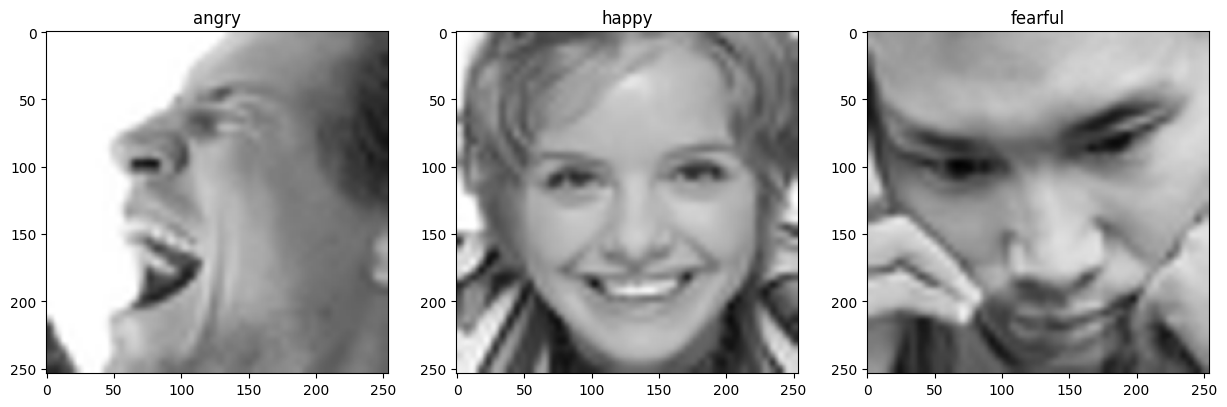

In [29]:
im_number = 3

fig, axes = plt.subplots(1, im_number)
fig.set_size_inches(5 * im_number, 5)

i = 0
with torch.no_grad():
    for img, label in test_dataloader:
        axes[i].imshow(img.squeeze(0).numpy().transpose(1, 2, 0))
        axes[i].set_title(classes[model(preprocess(img)).argmax(axis=1).item()])
        
        i += 1
        if i == im_number:
            break